# Including

In [1]:
using NBInclude
using Plots
using LaTeXStrings
using SparseArrays
using DataFrames
using ProgressBars
using Interpolations
using LinearAlgebra
@nbinclude("Hofstadter Single Particle in Julia.ipynb"; regex=r"#.*executeme")
@nbinclude(joinpath("..","First Band Approximation Functions.ipynb"))
@nbinclude(joinpath("../Braiding Utils.ipynb"));

# Model Parameters

$\phi=\frac{p}{q}=\frac{p}{N_y}, N_\phi=\phi NxNy=N_x \text{ (The number of single particle degeneracy)}$

In [220]:
4*pi/15

0.8377580409572781

In [244]:
Nx=9
Ny=15
N=Nx*Ny
p=1
q=Ny
NPhi = Int( Nx * Ny * (p/q) )
cut_off = NPhi
PN = [0,1,2,3,4] 
U=2;

# Sub Space Kinetic Term

In [245]:
sp_basis = NLevelBasis(N)
periodicity = 0 #periodic (select 1 for hard-wall conditions)
sp_matrix = Hofstadter_SP(Nx, Ny, p/q, periodicity);

In [246]:
H1 = get_sp_op(sp_basis, sp_matrix);

In [247]:
#eigenenergies(dense(H1)) == eigvals(sp_matrix) #true
eigenenergies(dense(H1));

In [248]:
sub_states = get_sub_states(H1, cut_off);

In [249]:
basis_sub, P, Pt = get_projector_op(sub_states, sp_basis);

In [250]:
H1_sub = get_subspace_op(H1, P, Pt);

In [251]:
num_sub_list = get_num_sub_list(N, sp_basis, P, Pt);

In [252]:
# ALTERNATIVE FOR CONSTRUCTING THE INTERACTION TERM

In [253]:
# H1M = H1.data;

In [254]:
# P1 = P.data
# P1t = Pt.data;

In [255]:
# @einsum H1_tildeM[i,j] := P1[i,k] * H1M[k,l] * P1t[l,j];

In [256]:
# H1_tilde = Operator(basis_sub, H1_tildeM);

In [257]:
# m = 1
# V2 = U/2 * transition(sp_basis,m,m)⊗transition(sp_basis,m,m)
# for m in 2:N
#     V2 += U/2 * transition(sp_basis,m,m)⊗transition(sp_basis,m,m)
# end

In [258]:
# V2M = V2.data;

In [259]:
# P2M = (P⊗P).data
# P2_dagM = (Pt⊗Pt).data;

In [260]:
# @einsum V2_tildeM[i2,j2] := P2M[i2,k2] * V2M[k2,l2] * P2_dagM[l2,j2];

In [261]:
# V2_tilde = Operator(basis_sub, V2_tildeM);

# Sub Space Hubbard Interaction Term

In [262]:
states_mb = bosonstates(basis_sub, PN) 
basis_mb = ManyBodyBasis(basis_sub, states_mb);

In [263]:
H1_MB = get_mb_op(basis_mb, H1_sub);

In [264]:
@nbinclude("Hofstadter MB in Julia.ipynb"; regex=r"#.*executeme");

In [265]:
basis_cut_mb, basis_cut_sp = get_Bosonic_MB_Basis(cut_off,PN);

In [266]:
# H_Int = Hubbard_Interaction(P, Pt, basis_cut_mb, cut_off, U);

In [267]:
H_Int = Hubbard_Interaction_op(P, Pt, basis_cut_mb, cut_off, U);

0.0%┣                                                ┫ 0/9 [00:00<00:00, -0s/it]
11.1%┣████▊                                      ┫ 1/9 [00:01<Inf:Inf, InfGs/it]
22.2%┣██████████▊                                     ┫ 2/9 [00:02<00:12, 2s/it]
33.3%┣████████████████                                ┫ 3/9 [00:03<00:10, 2s/it]
44.4%┣█████████████████████▍                          ┫ 4/9 [00:05<00:08, 2s/it]
55.6%┣██████████████████████████▊                     ┫ 5/9 [00:07<00:07, 2s/it]
66.7%┣████████████████████████████████                ┫ 6/9 [00:09<00:05, 2s/it]
77.8%┣█████████████████████████████████████▍          ┫ 7/9 [00:11<00:04, 2s/it]
88.9%┣██████████████████████████████████████████▊     ┫ 8/9 [00:13<00:02, 2s/it]
100.0%┣███████████████████████████████████████████████┫ 9/9 [00:15<00:00, 2s/it]
100.0%┣███████████████████████████████████████████████┫ 9/9 [00:15<00:00, 2s/it]


In [268]:
# H_NI_tilde_mb = manybodyoperator(basis_mb, H1_tilde);

# Vint_tilde_mb = manybodyoperator(basis_mb, V2_tilde);

# H_tilde_mb = H_NI_tilde_mb + Vint_tilde_mb;

# H_tilde_mb = (H_tilde_mb + H_tilde_mb')/2;

In [269]:
H_Kin = SparseOperator(basis_cut_mb)
H_Kin.data = H1_MB.data;

In [270]:
Sub_Number_MB_Operator_List = get_num_mb_op(N, basis_cut_sp, num_sub_list, basis_cut_mb, basis_sub);

0.0%┣                                              ┫ 0/135 [00:00<00:00, -0s/it]
100.0%┣███████████████████████████████████████┫ 135/135 [00:00<00:00, 11.3kit/s]
100.0%┣███████████████████████████████████████┫ 135/135 [00:00<00:00, 10.4kit/s]


In [271]:
Total_H = H_Kin + H_Int;

# Total Hamiltonian with Impurity Potential

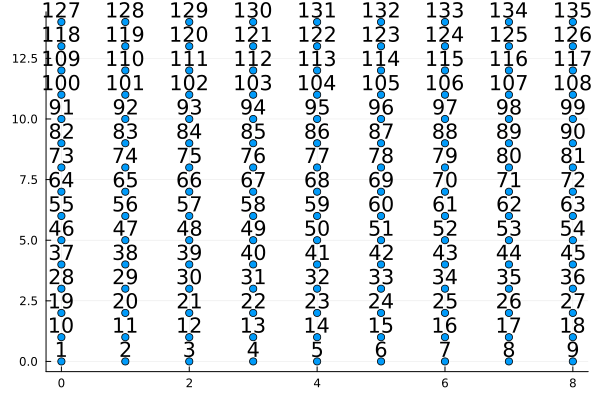

In [272]:
plot_square_lattice(Nx, Ny)

In [273]:
V0 = [4, 0]; Imp_Site = [102, 38]
Impurity_Data = Impurity(V0, Imp_Site)

Impurity([4.0, 0.0], [102, 38])

In [274]:
H_Impurity = Imp_H(Total_H, Sub_Number_MB_Operator_List, Impurity_Data)
H_Impurity = dense((H_Impurity'+H_Impurity)/2);

\begin{align*}
    &\text{Filling fraction:} \quad \nu=\frac{N}{N_{\Phi}} = \frac{3}{8}, \quad \text{Laughlin fraction: } \frac{N}{N_{\Phi}}=\frac{3}{6}=\frac{1}{2} => \text{There are 2 free quasi-particles.} \\
    &\text{So, added 2 flux in the lattice is mean that, +2 free quasi-particles. One of them is pinned.}
\end{align*}

# Exact Diagonalization

In [275]:
E, V = eigenstates(H_Impurity);

In [276]:
pn = maximum(PN)
filtered_energies = get_filtered_energies(pn, E, V, basis_cut_mb);

In [278]:
N_Pin = 1
nu0 = 1/2
NPhi0 = Nx*Ny*(p/q)
NPhi = NPhi0-N_Pin
N_d = Int(NPhi - pn/nu0)
Degeneracy = Int((factorial(N_d + pn - 1) / (factorial(N_d) * factorial(pn - 1))) * (NPhi / pn))

2

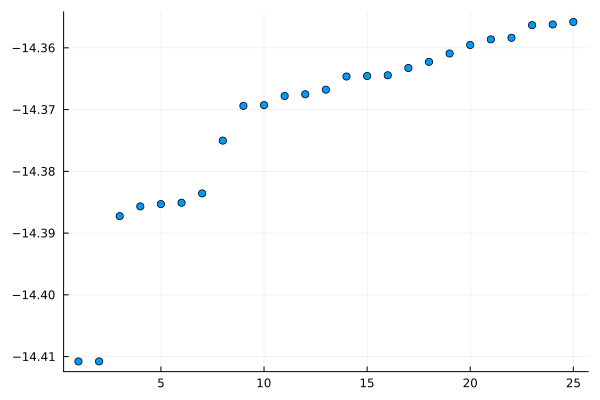

In [281]:
scatter(filtered_energies[1:25], legend=false)

In [178]:
# Onur hocanın makalesinde ki FIG1 çıktısı

# using Plots
# using LaTeXStrings
# Plots.plot(1:35, E0, seriestype=:scatter,xlabel=L"$n$",ylabel=L"$E$",title=L"$V_{imp}=0$",legend=false)
# #ylims!((-7.20544,-7.20536))

Alltaki fonksiyonun çalışması için, dizideki filtre edilmiş parçacık sayısı her zaman en büyük değerde olmalıdır.
Örneğin, `PN=[0,1,2,3,4]` iken filtre edilen parçacık sayısı `pn=4` olmalıdır!

In [282]:
r_hubbard_states = Restricted_Hubbard_States(V);

# Density Profile

In [283]:
avg_density = Get_Avg_Density(Nx, Ny, Degeneracy, N, Sub_Number_MB_Operator_List, basis_cut_mb, r_hubbard_states);

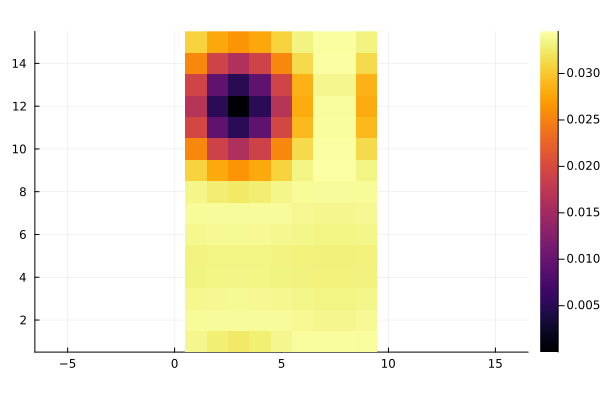

In [316]:
data = avg_density'
factor = 1

Plots.heatmap(Interp(data, factor), aspect_ratio=:equal)
#scatter!(co[:,1].+1,co[:,2].+1, series_annotations = text.([i for i in 1:N], :bottom), legend=false)

# Torus Distance and Equivalent (Periodic) Sites

In [102]:
@nbinclude("Torus_Distance.ipynb");

In [103]:
coordinates, latticee = get_square_lattice(Nx, Ny)
coordinates_top_left, coordinates_top, coordinates_top_right, coordinates_left, coordinates_right, coordinates_bottom_left, coordinates_bottom, coordinates_bottom_right, co_districts = get_ghost_sites(coordinates)
ref_coordinates = coordinates
ref_site = 36 # Site Pinned (Site 44 = Site 36) # BURASI GENEL DEĞİL SORUN YARATABİLİR!!!
radius_list = get_radii(ref_coordinates, coordinates, ref_site, N);

In [104]:
All_Coordinates, X_Coordinates, Y_Coordinates, All_Coordinates_2 = get_all_sites(Nx, Ny, coordinates);

# Density Plot and $Q_{\rho}$ Calculation

In [105]:
# # Density Plot
# index_eig_states = 1
# Plots.heatmap(Get_Avg_Density(Nx, Ny, Degeneracy, N, Sub_Number_MB_Operator_List, basis_cut_mb, r_hubbard_states)', colormap=:dense)

# # koordinatları 0 yerine 1'den başlatırsak heatmap ile uyumlu olur (.+1 operasyonu)
# x_coordinates = coordinates[:,1] .+1
# y_coordinates = coordinates[:,2] .+1
# Plots.scatter!(x_coordinates, y_coordinates, label=false, aspect_ratio=1, showaxis = false, grid=false, markersize=3, c=:black, title=L"$<n_i|\Psi_1|n_i>$", xlabel=L"$x$",ylabel=L"$y$")

# # Site Index
# for i in 1:N
#     p = Plots.annotate!(x_coordinates[i],y_coordinates[i], text("$i", :Courier, 10,:green))
# end

# # Circle
# function circle_shape(h,k,r)
#     beta = reverse(LinRange(0, 2*pi, 500))
#     h .+ r*sin.(beta), k .+ r*cos.(beta)
# end

# # Bu örnekte imp_site=44 aslında 36.site'dır. Çünkü burada density en düşüktür!
# center_x = x_coordinates[36]; center_y = y_coordinates[36]; radius = 1
# Plots.plot!(circle_shape(center_x,center_y,radius), seriestype=[:shape], lw=0.5, c=:red, linecolor= :red, legend=false, fillalpha=0.2)

# p

In [106]:
# Hangi siteler, ilgili yarı-çap içerisinde, şartını kontrol ediyoruz
function Inner_Sites(Radius)
    
    ref_district = coordinates # Center Distrinct
    Ref_Site_X = ref_district[:,1][ref_site]
    Ref_Site_Y = ref_district[:,2][ref_site]
    
    inner_sites = []
    
    for i in 1:Nx*Ny*9
        
        if (X_Coordinates[i] - Ref_Site_X)^2 + (Y_Coordinates[i] - Ref_Site_Y)^2 < (Radius+0.1)^2
            
            # Yarı-çap büyüdüğünde, periyodik noktalara sıçrayınca, "get_eq_site" fonksiyonu ile eş-değer siteleri buluyoruz.
            push!(inner_sites, get_eq_site(X_Coordinates[i], Y_Coordinates[i]))
        end
    end
    
    return inner_sites
end

Inner_Sites (generic function with 1 method)

\begin{align*}
&Q_{\rho} = \sum_i \left(<n_i>_{V=0}-<n_i>_{V \neq 0} \right) \\
&\text{Isotropic (uniform) reference particle density:}<n_i>_{V=0} \\
&<n_i>_{V=0} \approx \frac{N}{(N_\phi-1)N_y} = \frac{3}{70} \\
&Q=\frac{N}{N_\phi-1}=\frac{3}{7}
\end{align*}

In [107]:
radius_list

19-element Vector{Any}:
 0.0
 1.0
 1.4142135623730951
 2.0
 2.23606797749979
 2.8284271247461903
 3.0
 3.1622776601683795
 3.605551275463989
 4.0
 4.123105625617661
 4.242640687119285
 4.47213595499958
 5.0
 5.0990195135927845
 5.385164807134504
 5.656854249492381
 5.830951894845301
 6.4031242374328485

0.04285714285714286

In [111]:
function get_depletion_profile(radius_list, avg_density)
    
    density_list_1 = []
    density_list_2 = []
    depletion_prof = []
    
    for i in radius_list
        
        summ = 0
    
        for j in Inner_Sites(i)
            
            # r içindeki her bir sitenin ortalama yoğunluğu 
            push!(density_list_1, collect(Iterators.flatten((pn/((NPhi0-1)*Ny) .- avg_density|>transpose)))[j])
            # Örgüde sadece bir tane quasi-parçacık boştayken gelen neredeyse ortalama yoğunluk 3/70'tir!
            
            # aynı yoğunluklar gelirse sadece onların birisini tut
            density_list_2 = unique!(density_list_1)
            
            # her biri biricik ve her bir site için olan yoğunlukları topla
            summ = sum(density_list_2)
        end
        
        # Sitelerin toplam yoğunluklarını bir listede her bir yarı-çap için biriktir
        push!(depletion_prof, summ)
    end
    
    return depletion_prof
end

get_depletion_profile (generic function with 1 method)

In [112]:
depletion_prof = get_depletion_profile(radius_list, avg_density)
#Plots.plot(radius_list, depletion_prof, xlabel=L"\rho", ylabel=L"Q_{\rho}", title="Density (Charge) Depletion Profile", guidefontsize=17,legend=false, linewidth=3, xticks=0:1:12, yticks=0:0.10:0.46, m = (5, :white, stroke(1, :blue)))
# Q = pn/NPhi
# g(x)=Q; x=0
# Plots.plot!(g, x, length(radius_list), line=(:dot,2), xlim=(0,7))

19-element Vector{Any}:
 0.04285637031251483
 0.1749415652702963
 0.2751006349796604
 0.33414261920952615
 0.41846045284678335
 0.43282476999952657
 0.4443764239870234
 0.4554135628217351
 0.4531295274047951
 0.4514022974787381
 0.44536764920626054
 0.4421893904464302
 0.4365387535453289
 0.43053708476733477
 0.43053708476733477
 0.42935406014762695
 0.4289309572478751
 0.4285689595773482
 0.4285714285714288

# Berry Matrix

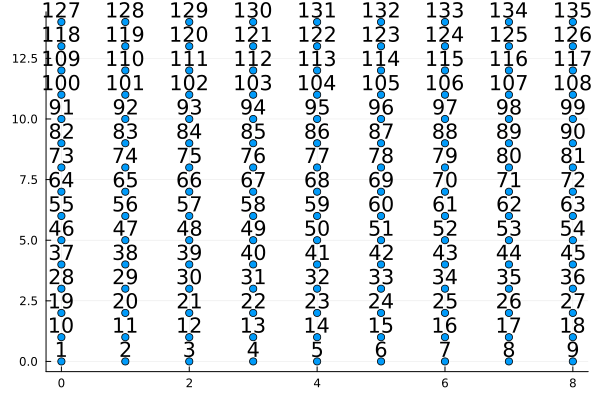

In [285]:
plot_square_lattice(Nx, Ny)

In [286]:
start_point_1 = Impurity_Data.Imp_Site[1]

102

In [189]:
Nx

10

In [292]:
lens_1 = [5, 5, 5, 5]
dirs_1 = [1, -Nx, -1, Nx]
rec_path_1 = unique(rectangular_path(start_point_1,lens_1,dirs_1))
rec_path_1 = append!(rec_path_1, 102)

21-element Vector{Int64}:
 102
 103
 104
 105
 106
 107
  98
  89
  80
  71
  62
  61
  60
  59
  58
  57
  66
  75
  84
  93
 102

In [293]:
start_point_2 = Impurity_Data.Imp_Site[2]

38

In [303]:
lens_2 = [4, 8]
dirs_2 = [-1, Nx]
rec_path_2 = unique(rectangular_path(start_point_2,lens_2,dirs_2))
rec_path_2=rec_path_1
# i = 38
# rec_path_2 = [ 38 for i in 1:9 ]

21-element Vector{Int64}:
 102
 103
 104
 105
 106
 107
  98
  89
  80
  71
  62
  61
  60
  59
  58
  57
  66
  75
  84
  93
 102

In [304]:
N_Pin = 4
V1 = Impurity_Data.V0[1]
V2 = Impurity_Data.V0[2]
delta_t = 0.05;

In [305]:
Imp_Site = [rec_path_1[1], rec_path_1[2], rec_path_2[1], rec_path_2[2]]
V0 = [V1, 0, V2, 0]
Impurity_Data = Impurity(V0, Imp_Site);

In [306]:
Impurity_H = Imp_H(Total_H, Sub_Number_MB_Operator_List, Impurity_Data)
Impurity_H = dense((Impurity_H+Impurity_H')/2);

In [307]:
E_Imp_0, U_Imp_0 = eigenstates(Impurity_H)
U_Imp_0 = hcat([U_Imp_0[i].data for i in 1:Degeneracy] ...);

In [308]:
U_first = copy(U_Imp_0);

In [309]:
STEP = 0:delta_t:1

0.0:0.05:1.0

In [310]:
Imp_Site_List = [ [imp, rec_path_1[idx+1], rec_path_2[idx], rec_path_2[idx+1] ] for (idx,imp) in (enumerate(rec_path_1[1:end-1])) ]
V0_List = [ [V1*(1-step), V1*step, V2*(1-step), V2*step] for step in STEP ];

In [311]:
Impurity_Data_List = [ [Impurity(V00, Imp_Sitee)] for Imp_Sitee in Imp_Site_List for V00 in V0_List ];

In [312]:
Impurity_H_List = [ Imp_H(Total_H, Sub_Number_MB_Operator_List, Impurity_Dataa[1]) for Impurity_Dataa in ProgressBar(Impurity_Data_List) ];

0.0%┣                                             ┫ 0/420 [00:00<00:-31, -0s/it]
0.2%┣                                          ┫ 1/420 [00:00<Inf:Inf, InfGs/it]
1.4%┣▋                                             ┫ 6/420 [00:00<00:25, 17it/s]
2.6%┣█▏                                           ┫ 11/420 [00:00<00:15, 28it/s]
3.8%┣█▊                                           ┫ 16/420 [00:00<00:11, 36it/s]
4.3%┣██                                           ┫ 18/420 [00:01<00:13, 31it/s]
5.2%┣██▍                                          ┫ 22/420 [00:01<00:11, 35it/s]
6.2%┣██▉                                          ┫ 26/420 [00:01<00:10, 38it/s]
7.4%┣███▎                                         ┫ 31/420 [00:01<00:09, 42it/s]
8.1%┣███▋                                         ┫ 34/420 [00:01<00:09, 43it/s]
9.0%┣████                                         ┫ 38/420 [00:01<00:09, 45it/s]
9.8%┣████▍                                        ┫ 41/420 [00:01<00:08, 45it/s]
10.5%┣████▋                 

In [313]:
# Impurity_H_List = [ dense((Impurity_HH+Impurity_HH')/2) for Impurity_HH in Impurity_H ]

In [314]:
for Impurity_HH in ProgressBar(Impurity_H_List)
    Impurity_HH = dense((Impurity_HH+Impurity_HH')/2)
    E_Imp, U_Imp = eigenstates(Impurity_HH)
    U_Imp = hcat([U_Imp[i].data for i in 1:Degeneracy] ...)
    A = U_Imp_0'*U_Imp
    A_inv = inv(A)
    U_Imp_0 = U_Imp*transpose(A_inv)
    U_Imp_0 = gram_schmidt(U_Imp_0)
end

0.0%┣                                              ┫ 0/420 [00:00<00:00, -0s/it]
0.2%┣                                          ┫ 1/420 [00:01<Inf:Inf, InfGs/it]
0.5%┣▎                                              ┫ 2/420 [00:02<10:57, 2s/it]
0.7%┣▍                                              ┫ 3/420 [00:02<08:07, 1s/it]
1.0%┣▌                                              ┫ 4/420 [00:03<07:01, 1s/it]
1.2%┣▋                                              ┫ 5/420 [00:04<06:30, 1it/s]
1.4%┣▊                                              ┫ 6/420 [00:04<06:12, 1it/s]
1.7%┣▉                                              ┫ 7/420 [00:05<06:06, 1it/s]
1.9%┣█                                              ┫ 8/420 [00:06<05:59, 1it/s]
2.1%┣█                                              ┫ 9/420 [00:07<06:05, 1it/s]
2.4%┣█                                             ┫ 10/420 [00:08<06:00, 1it/s]
2.6%┣█▏                                            ┫ 11/420 [00:09<05:52, 1it/s]
2.9%┣█▎                     

In [315]:
BerryEnergies, BerryStates = eigen(U_Imp_0' * U_first)
angle.(BerryEnergies)/pi

2-element Vector{Float64}:
 -0.46948668324656107
 -0.197179983420153

In [ ]:
BerryMatrix = Berry_Matrix(rec_path_1, rec_path_2, Degeneracy, delta_t)
BerryEnergies, BerryStates = eigen(BerryMatrix)
BerryEnergies

0.0%┣                                              ┫ 0/201 [00:00<00:00, -0s/it]
[ Info:  started timer at: 2023-10-11T15:40:11.339
[ Info:            4.5894439s: 4 seconds, 589 milliseconds
0.5%┣▏                                         ┫ 1/201 [00:05<Inf:Inf, InfGs/it]
[ Info:  started timer at: 2023-10-11T15:40:16.221
[ Info:             1.522575s: 1 second, 522 milliseconds
1.0%┣▌                                              ┫ 2/201 [00:06<21:18, 6s/it]
[ Info:  started timer at: 2023-10-11T15:40:17.745
[ Info:            2.0496447s: 2 seconds, 49 milliseconds
1.5%┣▊                                              ┫ 3/201 [00:08<13:59, 4s/it]
[ Info:  started timer at: 2023-10-11T15:40:19.798
[ Info:            2.7245218s: 2 seconds, 724 milliseconds
2.0%┣█                                              ┫ 4/201 [00:11<12:15, 4s/it]
[ Info:  started timer at: 2023-10-11T15:40:22.524
[ Info:            1.5900283s: 1 second, 590 milliseconds
2.5%┣█▏                                         

LoadError: InterruptException:

In [ ]:
angle.(BerryEnergies)/pi

LoadError: UndefVarError: `BerryEnergies` not defined

In [48]:
movie(delta_t, 1, Nx, Ny, Degeneracy, N, Sub_Number_MB_Operator_List, basis_cut_mb, co)

!Nx and Ny must be equalt to each other!


[ Info: Saved animation to C:\Users\Can\Downloads\Git File\Kagome-Lattice\My Numerical Calculations\Many-Body\Hofstadter\tmp.gif
